# Implementing BERT on Hate Speech Classification Dataset

In this project we train BERT (Bidirectional Encoder Representations from Transformers), an ML model for natural language processing (NLP) introduced by Google AI in 2018 on the dataset [Hate_Speech_Offensive](https://huggingface.co/datasets/tdavidson/hate_speech_offensive) given in HuggingFace. The goal is to preprocess the data properly and finetune parameters of BERT to achieve high classification recall.

## Loading and importing necessary modules

The following modules are necessary for implementation. Uncomment the cell contents below and run it if your system does not have any of these preinstalled.

In [19]:
#Use to install required modules
'''
!pip install import-ipynb
!pip install nlpaug
!pip install numpy
!pip install torch
!pip install 'accelerate>={ACCELERATE_MIN_VERSION}'
!pip install sklearn
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install transformers
!pip install datasets
'''

"\n!pip install import-ipynb\n!pip install nlpaug\n!pip install numpy\n!pip install torch\n!pip install 'accelerate>={ACCELERATE_MIN_VERSION}'\n!pip install sklearn\n!pip install scikit-learn\n!pip install seaborn\n!pip install matplotlib\n!pip install pandas\n!pip install transformers\n!pip install datasets\n"

In [44]:
import torch
import os
import numpy as np
import re
import random
import warnings
import nlpaug.augmenter.word as naw
import pandas as pd
import accelerate
import seaborn as sns
import matplotlib.pyplot as plt
import transformers

from datasets import load_dataset, DatasetDict, ClassLabel
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, logging
from hatedataset import HateSpeechDataset

BERT is a very complex model using transformer architecture, transfer learning, bidirectional language processing and many other modern methods. To ensure fast processing, we use parallel processing and GPUs. This code was run on the GreatLakes cluster for high processing speeds. The following code sets the device to MPS (for Apple devices) and CUDA (for Windows devices) for using GPUs.

In [21]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple Metal
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU
else:
    device = torch.device("cpu")  # Fallback to CPU

## Data Exploration and Preprocessing

In [22]:
# Load dataset from Hugging Face
dataset = load_dataset("tdavidson/hate_speech_offensive")

# Convert dataset to pandas DataFrame for easier manipulation
df = pd.DataFrame(dataset['train'])
print(f"The shape of the dataset is {df.shape} with columns {list(df.columns)}.")

The shape of the dataset is (24783, 6) with columns ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'].


The data contains 6 columns. 'Count' represents the number of users who were tasked with classifying the tweet in column 'Tweet'. 'Hate_speech_count', 'offensive_language_count' and	'neither_count' contains the number of users who classified the tweet as hate speech, offensive and neither respectively. Based on majority, the tweets were classified into **0: Hate Speech, 1: Offensive and 2: Neutral** which is stored in the column 'Class'. Let us look at the first few rows,

In [23]:
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


The tweets in the data have userids and URLs which is unnecessary for hate speech classification. It also has too much whitespace in some tweets. So we clean the tweets for faster processing and higher classification quality.
## Data Cleaning

In [24]:
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with <empty string>
    2) lots of whitespace with one instance
    3) mentions with <empty string>
    """
    space_pattern = r'\s+'
    giant_url_regex = (r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        r'[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = r'@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text
df['tweet']=df['tweet'].apply(preprocess)
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitc...
3,3,0,2,1,1,!!!!!!!!! RT : she look like a tranny
4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


## Data Augmentation and Downsampling

Let us check the proportion of hate speech, offensive and neutral speech data. The following is the barplot of these 3 classes,

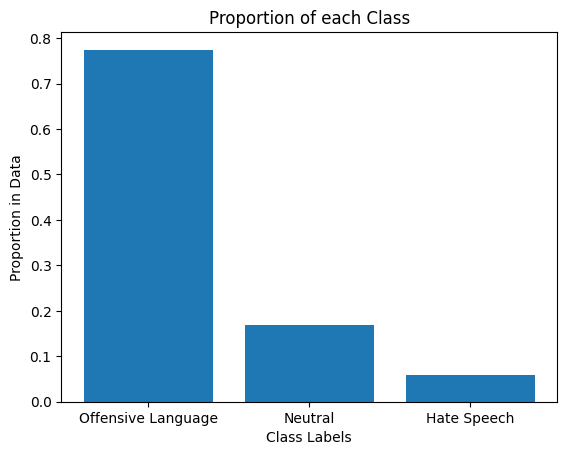

In [25]:
value_counts = df['class'].value_counts()
index_mapping={0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neutral'}
value_counts=value_counts.rename(index=index_mapping)

# Bar plot
plt.bar(value_counts.index, value_counts.values/sum(value_counts.values))
plt.xlabel('Class Labels')
plt.ylabel('Proportion in Data')
plt.title('Proportion of each Class')
plt.savefig("bplot_b4proc.png")
plt.show()

As can be seen, this dataset is highly imbalanced with around 76% offensive data and only 19% neutral and 5% hate speech data. To avoid misclassifications and reduce the influence of offensive data, we adopt three main techniques: data augmentation, downsampling and assigning class weightage while training BERT. We use the classical module **nlpaug** for augmentation. We implement class weighting while training which we will see later. One unfortunate problem is nlpaug does not support Apple Metal GPUs, so we revert to CUDA or CPUs.

In [26]:
if torch.cuda.is_available():
    device_aug = "cuda"  # Use NVIDIA GPU
else:
    device_aug = "cpu"  # Fallback to CPU


random_state=42 #Fixing randomness for reproducibility

aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased',  # Use BERT as the model
    action="substitute",            # Replace words with context-aware alternatives
    top_k=5,                       # Choose from top 5 predictions
    device=device_aug
)
def augment_df_with_context(df, augmenter, num_augment, num_thread=os.cpu_count()):
    augmented_df = pd.DataFrame(columns=df.columns)
    c,i=0,1
    for idx in df.index:
        c+=1
        try:
            text_to_augment = df.at[idx, 'tweet']
            # Use num_thread for parallelism in augment
            if device_aug=="cpu":
                aug_sent_list = augmenter.augment(text_to_augment, n=num_augment, num_thread=num_thread)
            else: aug_sent_list = augmenter.augment(text_to_augment, n=num_augment)

            # Append augmented rows
            for sent in aug_sent_list:
                new_row = df.loc[idx].copy()
                new_row['tweet'] = sent
                augmented_df = pd.concat([augmented_df, pd.DataFrame([new_row])], ignore_index=True)

        except Exception as e:
            print(f"Error augmenting row {idx}: {e}")
        if 2*c>=i*df.shape[0]:
            i+=1
            print("Done with half of dataframe!")
    return augmented_df

def aug_dataframe(orig_df,augmenter,target_count):
    """
    Takes the original tweets dataframe and augments new tweets
    using given nlpaug augmenter. Augments tweets till ~ target_count for each
    class is reached
    """
    counts=orig_df['class'].value_counts()
    augmented_data=orig_df
    for class_label, count in counts.items():
        if count>=target_count: continue
        class_samples = orig_df[orig_df['class']==class_label]
        #take necessary amount of samples for augmentation
        class_samples=class_samples.sample(n=min(target_count-count,count),random_state=random_state)
        aug_sample= augment_df_with_context(class_samples,augmenter,max(int((target_count-count)/count),1))
        # Append to augmented data
        augmented_data=pd.concat([augmented_data,aug_sample],axis=0)
    return augmented_data

In [49]:
def sample_and_combine(df, sample_size):
    """
    Samples indices for offensive speech and combines them with non-offensive indices.

    Args:
        df (pd.DataFrame): Input DataFrame with imbalanced classes.
        sample_size (int): Number of offensive indices to sample.

    Returns:
        pd.DataFrame: ~Balanced DataFrame with sampled offensive and all non-offensive entries.
    """
    random.seed(random_state)
    offensive_df = df[df['class'] == 1]
    non_offensive_df = df[df['class'] != 1]

    # Sample offensive entries
    sampled_offensive = offensive_df.sample(n=sample_size, random_state=random_state)

    # Concatenate with non-offensive without changing its size
    balanced_df = pd.concat([sampled_offensive, non_offensive_df])

    return balanced_df.reset_index(drop=True)

## Train-Test Split

We adopt a train-test split ratio of 80-20.

In [28]:
# Split the data
train_df, test_df= train_test_split(
    df, test_size=0.2, random_state=42
)
'''
print(train_df.shape)   #Uncomment to see shape of training data
c1=train_df['class'].value_counts()
print(c1)        #Uncomment to see class distribution
'''

"\nprint(train_df.shape)   #Uncomment to see shape of training data\nc1=train_df['class'].value_counts()\nprint(c1)        #Uncomment to see class distribution\n"

In [29]:
train_df=aug_dataframe(train_df,aug,4000)
#Above code should print 4 test messages, 2 for augmenting neutral data,
#2 for hate speech

balanced_train_df=sample_and_combine(train_df,10000)
'''
print(train_df.shape) #Uncomment to see shape post-augmentation
c2=train_df['class'].value_counts()
print(c2)        #Uncomment to see class distribution post augmentation
count=balanced_train_df['class'].value_counts()
print(count)
'''

Done with half of dataframe!
Done with half of dataframe!
Done with half of dataframe!
Done with half of dataframe!


"\nprint(train_df.shape) #Uncomment to see shape post-augmentation\nc2=train_df['class'].value_counts()\nprint(c2)        #Uncomment to see class distribution post augmentation\ncount=balanced_train_df['class'].value_counts()\nprint(count)\n"

Let us view the class proportion barplot again. We chose a target augmentation count of ~4000 and downsampling size of 10000. As expected we see ~57% offensive speech data and ~20% data for hate and neutral speech each. We don't do further downsampling to not lose essential features of offensive speech and restrict ourselves to 4000 to control the impact of synthetic data.

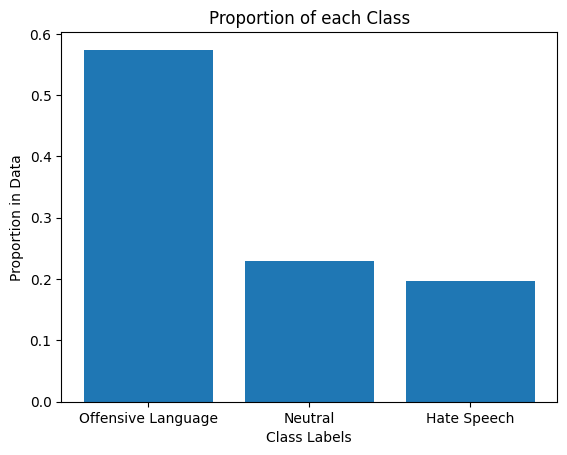

In [33]:
value_counts = balanced_train_df['class'].value_counts()
index_mapping={0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neutral'}
value_counts=value_counts.rename(index=index_mapping)

# Bar plot
plt.bar(value_counts.index, value_counts.values/sum(value_counts.values))
plt.xlabel('Class Labels')
plt.ylabel('Proportion in Data')
plt.title('Proportion of each Class')
plt.savefig("bplot_afproc.png")
plt.show()

Next we initialize the BERT Tokenizer and tokenize the balanced training dataset.

In [34]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [35]:
# Tokenize the text splits
train_encodings = tokenizer(list(balanced_train_df['tweet']), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_df['tweet']), truncation=True, padding=True, max_length=128)

The last step we take for reducing the effect of class imbalance is to calculate class weights and introduce a weighted loss function with a custom trainer called **MyTrainer**.

In [36]:
# Class distribution
class_counts = [balanced_train_df[balanced_train_df['class']==i].shape[0] for i in range(3)]
class_labels = [0, 1, 2]  # Corresponding to the classes

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=np.repeat(class_labels, class_counts))

# Convert to tensor for PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights: {class_weights}")


Class weights: tensor([1.6979, 0.5807, 1.4517], device='cuda:0')


In [41]:
class MyTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels").to(self.args.device)
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]
        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            # loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            logits = outputs['logits']
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            loss = criterion(logits, inputs['labels'].to(self.args.device))
        return (loss, outputs) if return_outputs else loss

## Training BERT

We are finally at the stage of training BERT after all the preprocessing. We fine tune the parameters for BERT to avoid overfitting. For example, we freeze initial few layers of BERT as that is mostly for grammar and syntax. However, given these are tweets, there is not much to learn from these aspects for hate speech classification. We provide brief explanation in comments for other tuning aspects.

In [43]:
train_dataset = HateSpeechDataset(train_encodings, balanced_train_df['class'].tolist())
test_dataset = HateSpeechDataset(test_encodings, test_df['class'].tolist())

# Load pre-trained BERT with a classification head
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3,hidden_dropout_prob=0.2)
#usually hidden_dropout_prob is set to 0.1 by default, we increase it slightly to encourage random dropping out of specific neurons

for param in model.bert.encoder.layer[:8].parameters():
    param.requires_grad = False
#freezing initial few layers as discussed
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.02,  #usually 0.01, we increase it to reduce overfitting
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True, #set to True to use the best model among the epochs
    push_to_hub=False,
    report_to="none",  # Avoid logging to remote services
    dataloader_num_workers=4,
    disable_tqdm=False,  #Enables progress bar rendering instead of printing a report per epoch
    optim="adamw_torch",
    fp16=True if torch.cuda.is_available() else False  # Enable mixed precision if GPU supports
)

trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights
)

# Train the model
trainer.train()

warnings.filterwarnings("ignore", message="Some weights of .* were not initialized")
warnings.filterwarnings("ignore", category=FutureWarning)
transformers.logging.set_verbosity_error()  # Suppress transformers logging

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-41-19864cc46ee3>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MyTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.606100,0.534786
2,0.460200,0.489687
3,0.386300,0.597315
4,0.315100,0.736051
5,0.262100,0.674493
6,0.210500,0.771928
7,0.171500,0.857351
8,0.137200,0.911022


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

Epoch,Training Loss,Validation Loss
1,0.606100,0.534786
2,0.460200,0.489687
3,0.386300,0.597315
4,0.315100,0.736051
5,0.262100,0.674493
6,0.210500,0.771928
7,0.171500,0.857351
8,0.137200,0.911022
9,0.126300,0.962597
10,0.096700,1.045995


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


NameError: name 'transformers' is not defined

We now evaluate the performance of our model on the test dataset. we start with defining a metric function, which we use to get various evaluation metrics.

In [45]:
# Define the function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Reuse the trainer for evaluation
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights,
    compute_metrics=compute_metrics
)


# Evaluate the model on the test dataset
results = trainer.evaluate(test_dataset)
print("Evaluation Results:", results)


warnings.filterwarnings("ignore", message="Some weights of .* were not initialized")
warnings.filterwarnings("ignore", category=FutureWarning)
transformers.logging.set_verbosity_error()  # Suppress transformers logging

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.4896867573261261, 'eval_model_preparation_time': 0.0057, 'eval_accuracy': 0.8767399636877143, 'eval_precision': 0.911861952604963, 'eval_recall': 0.8767399636877143, 'eval_f1': 0.8903876816638172, 'eval_runtime': 29.4696, 'eval_samples_per_second': 168.207, 'eval_steps_per_second': 21.039}


We can see that all of accuracy, precision, recall have sufficiently high values, which indicates that the model performs well overall! Now let us check its performance inside each class,

In [46]:
# Get raw predictions
predictions = trainer.predict(test_dataset)

# Extract logits and predicted labels
logits = predictions.predictions
predicted_labels = logits.argmax(axis=-1)

# Map numeric labels to classes if a label map exists
label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neutral"}
predicted_classes = [label_map[label] for label in predicted_labels]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [47]:
# Generate a classification report
true_labels = test_df['class'].tolist()
print(classification_report(true_labels, predicted_labels, target_names=label_map.values()))

                    precision    recall  f1-score   support

       Hate Speech       0.33      0.63      0.43       290
Offensive Language       0.97      0.89      0.93      3832
           Neutral       0.87      0.89      0.88       835

          accuracy                           0.88      4957
         macro avg       0.72      0.80      0.74      4957
      weighted avg       0.91      0.88      0.89      4957



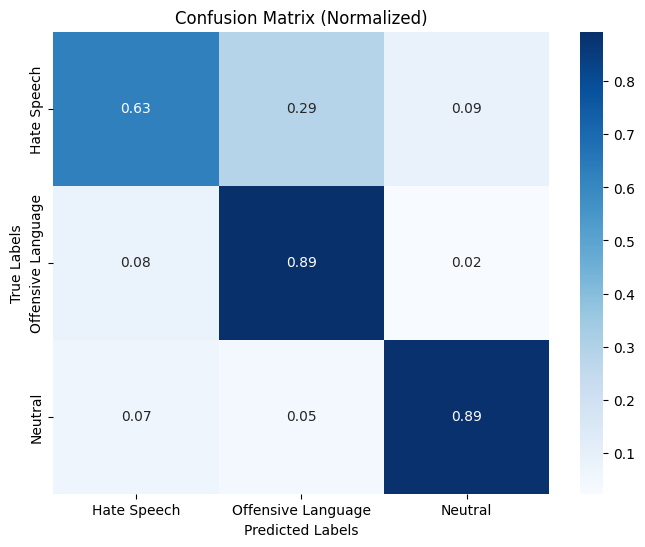

In [48]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix to probabilities
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix with lighter color scheme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=label_map.values(), yticklabels=label_map.values())

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Normalized)')
plt.savefig("confusion_matrix.png", format='png', dpi=300)  # Save as PNG
plt.show()


The classification report and the confusion matrix above show that apart from Hate Speech, all the other classes have been classified quite well. Offensive speech has been classified the best. Hate Speech classification is lagging behind significantly, but it succeeds in classifying more than 60% of the time.

## Conclusion
The model performs very well overall, but lags behind in hate speech classification. This is largely because of the fact that the original dataset had very few hate speech instances. The data had only 5% hate speech instances and after significant data preprocessing, the metrics could not be improved further. However, the preprocessing has definitely helped a lot, as earlier in the proposal we saw the recall was just 0.24. BERT is limited by the quality of data in this case; access to better data is definitely recommended for this classification problem.